# Self-supervised and multi-modal representation Learning: Notebook 3

Here we will align the image and light curve representations with contrastive learning, using CLIP (https://openai.com/research/clip). 

- From https://openai.com/research/clip.

## Aligning light curves and galaxy images in a common embedding space

In [1]:
import os, sys
import numpy as np
import pandas as pd
import math
from typing import Dict, Optional
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
from einops import rearrange
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl
from torch.utils.data import TensorDataset, DataLoader, random_split
from torchvision.transforms import RandomRotation
from torch.utils.data import TensorDataset, DataLoader, random_split
from src.models_multimodal import (
    ConvMixer,
    TransformerWithTimeEmbeddings,
    LightCurveImageCLIP,
)
from src.utils import (
    get_valid_dir,
    LossTrackingCallback,
    plot_loss_history,
    get_embs,
    find_indices_in_arrays,
    get_AUC,
    LossTrackingCallback,
    cosine_similarity, 
    plot_ROC_curves,
    get_ROC_data
)
from src.dataloader import (
    load_images,
    load_lightcurves,
    plot_lightcurve_and_images,
    load_spectras,
    load_data,
    NoisyDataLoader,
)
from src.loss import sigmoid_loss, clip_loss
from typing import Tuple
from src.transformer_utils import Transformer

from IPython.display import Image as IPImage

%load_ext autoreload
%autoreload 2

### Data preprocessing

Load host images and inspect shape.

In [3]:
max_data_len = 100 # Spectral data is cut to this length
dataset, nband = load_data("./data/ZTFBTS/", max_data_len=max_data_len, host_galaxy=True)

light curve and host galaxy
Loading images...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5171/5171 [00:02<00:00, 1943.82it/s]


Loading light curves...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5170/5170 [00:06<00:00, 743.74it/s]


### Create dataset

In [253]:
number_of_samples = len(dataset)

val_fraction = 0.05
batch_size = 32
n_samples_val = int(val_fraction * number_of_samples)

dataset_train, dataset_val = random_split(
    dataset, [number_of_samples - n_samples_val, n_samples_val]
)

train_loader_no_aug = NoisyDataLoader(
    dataset_train, batch_size=batch_size, noise_level_img=0, noise_level_mag=0, combinations=['host_galaxy', 'lightcurve'], num_workers=1, pin_memory=True, shuffle=True
)
val_loader_no_aug = NoisyDataLoader(
    dataset_val, batch_size=batch_size, noise_level_img=0, noise_level_mag=0, combinations=['host_galaxy', 'lightcurve'], num_workers=1, pin_memory=True, shuffle=False
)

# Define the noise levels for images and magnitude (multiplied by magerr)
noise_level_img = 1  # Adjust as needed
noise_level_mag = 1  # Adjust as needed

val_noise = 0

# Create custom noisy data loaders
train_loader = NoisyDataLoader(
    dataset_train,
    batch_size=batch_size,
    noise_level_img=noise_level_img,
    noise_level_mag=noise_level_mag,
    combinations=['host_galaxy', 'lightcurve'], 
    shuffle=True,
    num_workers=8,
    pin_memory=True,
)
val_loader = NoisyDataLoader(
    dataset_val,
    batch_size=batch_size,
    noise_level_img=val_noise,
    noise_level_mag=val_noise,
    combinations=['host_galaxy', 'lightcurve'],
    shuffle=False,
    num_workers=8,
    pin_memory=True,
)

### Contrastive-style losses

The standard CLIP architecture uses a bidirection (symmetric between modalities, e.g. image and text) version of the so-called SimCLR loss to compute alignment between image and light curve representations.
$$\mathcal{L}_\mathrm{CLIP}=-\frac{1}{2|\mathcal{B}|} \sum_{i=1}^{|\mathcal{B}|}\left(\log \frac{e^{t\,x_i \cdot y_i}}{\sum_{j=1}^{|\mathcal{B}|} e^{t\,x_i \cdot y_j}}+\log \frac{e^{t\,x_i \cdot y_i}}{\sum_{j=1}^{|\mathcal{B}|} e^{t\,x_j \cdot y_i}}\right)$$

The standard CLIP loss can be quite unstable due to the small number of positive pairs and large number of negative pairs in a batch. It can also often require very large batch sizes to work well. There are many proposed ways of overcoming this, e.g. see https://lilianweng.github.io/posts/2021-05-31-contrastive/ for some approaches. 

In addition to theh softmax-based loss, we'll also try a sigmoid loss, from https://arxiv.org/abs/2303.15343:
$$\mathcal{L}_\mathrm{SigLIP}=-\frac{1}{|\mathcal{B}|} \sum_{i=1}^{|\mathcal{B}|} \sum_{j=1}^{|\mathcal{B}|} \log \frac{1}{1+e^{z_{i j}\left(-t\, {x}_i \cdot {y}_j+b\right)}}$$
where $x_i$ and $y_j$ are the normalized image and light curve representations, respectively, and $z_{ij}$ is a binary indicator of whether the image and light curve are a match or not.

Let's implement these two.

In [39]:
transformer_kwargs = {"n_out": 32, "emb": 32, "heads": 2, "depth": 3, "dropout": 0.0}
conv_kwargs = {
    "dim": 32,
    "depth": 2,
    "channels": 3,
    "kernel_size": 5,
    "patch_size": 10,
    "n_out": 32,
    "dropout_prob": 0.0,
}
optimizer_kwargs = {"weight_decay": 0.0}

clip_model = LightCurveImageCLIP(
    logit_scale=20.0,
    lr=5e-4,
    loss="softmax",
    transformer_kwargs=transformer_kwargs,
    conv_kwargs=conv_kwargs,
    combinations=['host_galaxy', 'lightcurve']
)

In [40]:
loss_tracking_callback = LossTrackingCallback()
trainer = pl.Trainer(
    max_epochs=50, accelerator="gpu", callbacks=[loss_tracking_callback]
)
trainer.fit(
    model=clip_model, train_dataloaders=train_loader, val_dataloaders=val_loader
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-82e96326-37f6-5362-b068-99d475b9c87d]

  | Name                  | Type                          | Params
------------------------------------------------------------------------
0 | lightcurve_encoder    | TransformerWithTimeEmbeddings | 38.9 K
1 | lightcurve_projection | Linear                        | 4.2 K 
2 | image_encoder         | ConvMixer                     | 80.3 K
3 | image_projection      | Linear                        | 4.2 K 
  | other params          | n/a                           | 2     
------------------------------------------------------------------------
127 K     Trainable params
0         Non-trainable params
127 K     Total params
0.511     Total estimated model params size (MB)


Epoch 49: 100%|██████████| 154/154 [00:06<00:00, 23.44it/s, v_num=20, val_loss=3.180, AUC_val=0.693, train_loss=3.110]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 154/154 [00:06<00:00, 23.05it/s, v_num=20, val_loss=3.180, AUC_val=0.693, train_loss=3.110]


Play around with various hyperparameters. Does the loss go down/converge? **Is there actually a strong correlation between the host images and light curves?** How can you test this? (E.g. -> overfit on a small batch).

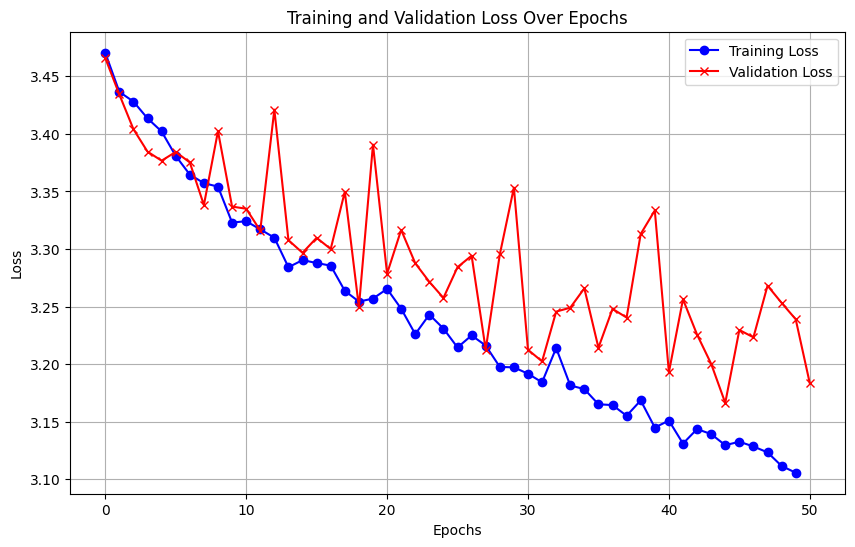

In [41]:
train_loss_history, val_loss_history = (
    loss_tracking_callback.train_loss_history,
    loss_tracking_callback.val_loss_history,
)

# Create a figure and a set of subplots
plt.figure(figsize=(10, 6))

# Plot training loss
plt.plot(
    train_loss_history, label="Training Loss", color="blue", linestyle="-", marker="o"
)

# Plot validation loss
plt.plot(
    val_loss_history, label="Validation Loss", color="red", linestyle="-", marker="x"
)

# Adding title and labels
plt.title("Training and Validation Loss Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")

# Adding a legend
plt.legend()

# Show grid
plt.grid(True)

## Downstream task: retrieval

Try your hand at various downstream tasks: compute embeddings over images, see if they are able to identify similar images/light curves better than the base model. See if the model has learned useful joint representations by trying retrieval across modalities (image to light curve and vice versa).

Looks like we can pick up similar light curves. Can you improve the model -- the light curves encoder (see last notebook), the image model, or the loss function?

In [ ]:
embs_curves_train, embs_images_train = get_embs(clip_model, train_loader_no_aug, combinations=['lightcurve', 'host_galaxy'])
embs_curves_val, embs_images_val = get_embs(clip_model, val_loader_no_aug, combinations=['lightcurve', 'host_galaxy'])

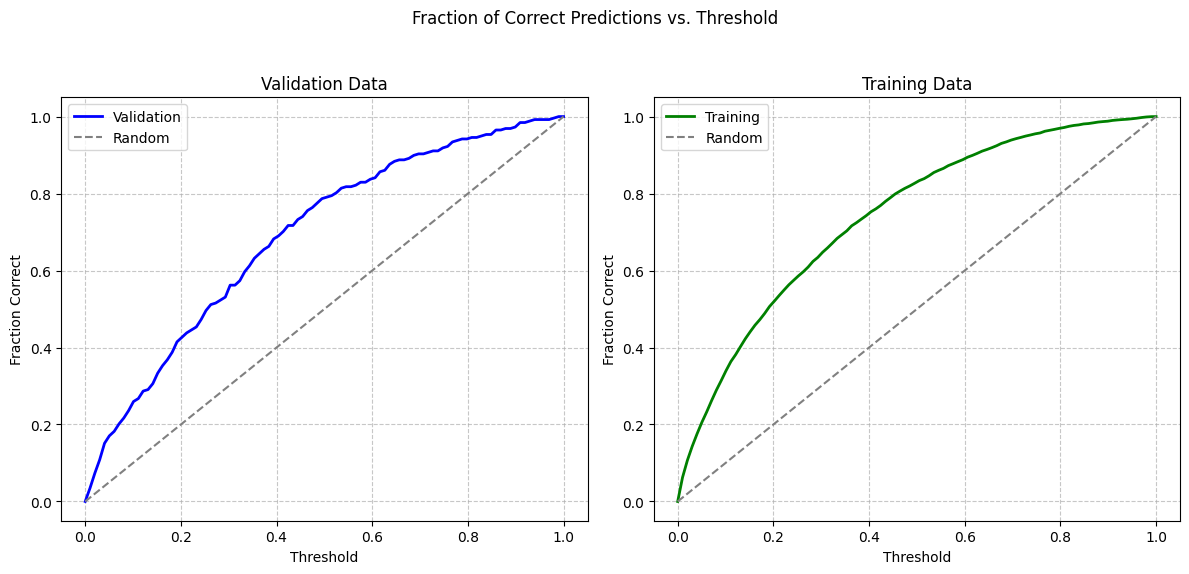

In [43]:
plot_ROC_curves(embs_curves_train, embs_images_train, embs_curves_val, embs_images_val)

### Downstream tasks: detecting interesting samples

Once we have a trained model, as a way of validation, we can take a lightcurve and find the top $n$ embeddings of images that most closely align with this lightcurve's embedding. Let's say for now that we are interested in looking at one of the SLSN-I lightcurves. 

In [37]:
# load the filenames of SLSN-I supernovae 
df = pd.read_csv(f"./data/ZTFBTS/ZTFBTS_TransientTable.csv")
filenames_SLSNI = df[df['type']=='SLSN-I']['ZTFID'].to_list()[0:1]

In [35]:
filenames = df['ZTFID'].to_list()

In [44]:
# load the data for SLSN-I supernovae and all of the images 
ims_SLSNI, _ = load_images("./data/ZTFBTS", [f + '.host.png' for f in filenames_SLSNI])
ims, ims_names = load_images("./data/ZTFBTS")
time_ary, mag_ary, magerr_ary, mask_ary, _, lc_names = load_lightcurves("./data/ZTFBTS")

#freq_ary_SLSNI, spec_ary_SLSNI, specerr_ary_SLSNI, mask_ary_SLSNI, spec_names_SLSNI = load_spectras("./data/ZTFBTS_spectra/", 
#                                                                                                    filenames=[f + '.csv' for f in filenames_SLSNI])
time_ary_SLSNI, mag_ary_SLSNI, magerr_ary_SLSNI, mask_ary_SLSNI, _, lc_names_SLSNI = load_lightcurves("./data/ZTFBTS", 
                                                                                                      filenames=[f + '.csv' for f in filenames_SLSNI])

Loading images...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 798.00it/s]


Loading images...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5171/5171 [00:02<00:00, 2155.59it/s]


Loading light curves...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5170/5170 [00:07<00:00, 654.30it/s]


Loading light curves...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 218.49it/s]


In [7]:
from ruamel.yaml import YAML

# load a trained model and its config 
cfg = YAML(typ='safe').load(open("./models/lightcurve-galaxy/config.yaml"))
print(cfg)

transformer_kwargs = {
        "n_out": cfg['n_out'],
        "emb": cfg["emb"],
        "heads": cfg['heads'],
        "depth": cfg["transformer_depth"],
        "dropout": cfg["dropout"],
    }

transformer_spectral_kwargs = {
    "n_out": cfg['n_out'],
    "emb": cfg["emb_spectral"],
    "heads": cfg['heads'],
    "depth": cfg["transformer_depth_spectral"],
    "dropout": cfg["dropout"],
}

conv_kwargs = {
    "dim": 32,
    "depth": 2,
    "channels": 3,
    "kernel_size": 5,
    "patch_size": 10,
    "n_out": cfg['n_out'],
    "dropout_prob": cfg["dropout"],
}

model = clip_model = LightCurveImageCLIP(
        logit_scale=cfg['logit_scale'],
        lr=cfg["lr"],
        nband=2,
        loss="softmax",
        transformer_kwargs=transformer_kwargs,
        transformer_spectral_kwargs=transformer_spectral_kwargs,
        conv_kwargs=conv_kwargs,
        optimizer_kwargs={},
        combinations=['host_galaxy', 'lightcurve'],
    )

model.load_state_dict(torch.load('./models/lightcurve-galaxy/epoch=71-step=11088.ckpt',  map_location=torch.device('cpu'))['state_dict'])

{'batchsize': 32, 'dropout': 0.0017494544885012654, 'emb': 32, 'emb_spectral': 32, 'epochs': 500, 'heads': 4, 'heads_spectral': 4, 'logit_scale': 1.577159593506111, 'lr': 0.0005623670359026817, 'max_spectra_len': 1000, 'n_out': 32, 'seed': 0, 'transformer_depth': 9, 'transformer_depth_spectral': 9, 'weight_decay': 3.3308706465608236e-05}


<All keys matched successfully>

In [55]:
# get embeddings of all images and the first lightcurve in filenames_SLSNI  
ims_emb_SLSNI = model.image_embeddings_with_projection(torch.tensor(ims_SLSNI))
lc_emb_SLSNI = model.lightcurve_embeddings_with_projection(torch.from_numpy(mag_ary_SLSNI).to(torch.float32),
                                                     torch.from_numpy(time_ary_SLSNI).to(torch.float32),
                                                     torch.from_numpy(mask_ary_SLSNI).to(torch.bool))

/var/folders/y1/n43fk0m97tg8sbqh5j222kqw0000gn/T/ipykernel_61776/829464774.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ims_emb_SLSNI = model.image_embeddings_with_projection(torch.tensor(ims_SLSNI))


In [56]:
ims_emb = model.image_embeddings_with_projection(torch.tensor(ims))
lc_emb = model.lightcurve_embeddings_with_projection(torch.from_numpy(mag_ary).to(torch.float32),
                                                     torch.from_numpy(time_ary).to(torch.float32),
                                                     torch.from_numpy(mask_ary).to(torch.bool))

/var/folders/y1/n43fk0m97tg8sbqh5j222kqw0000gn/T/ipykernel_61776/558638057.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ims_emb = model.image_embeddings_with_projection(torch.tensor(ims))


In [215]:
SN_types = [df.loc[df['ZTFID'] == x, 'type'].values[0] for x in lc_names]

In [58]:
# get their cosine similarity
cos_sim_lc = cosine_similarity(lc_emb, lc_emb_SLSNI)

In [59]:
cos_sim_im = cosine_similarity(ims_emb, ims_emb_SLSNI)

In [196]:
joint_emb = torch.cat((ims_emb, lc_emb),1)
joint_emb_SLSNI = torch.cat((ims_emb_SLSNI, lc_emb_SLSNI),1)

In [197]:
cos_sim_joint = cosine_similarity(joint_emb, joint_emb_SLSNI)

In [210]:
np.unique(SN_types)

array(['Ca-rich', 'ILRT', 'LBV', 'LRN', 'SLSN-I', 'SLSN-II', 'SN II',
       'SN II-pec', 'SN IIP', 'SN IIb', 'SN IIn', 'SN Ia', 'SN Ia-91T',
       'SN Ia-91bg', 'SN Ia-CSM', 'SN Ia-SC', 'SN Ia-pec', 'SN Iax',
       'SN Ib', 'SN Ib-pec', 'SN Ib/c', 'SN Ibn', 'SN Ic', 'SN Ic-BL',
       'SN Ic-pec', 'SN Icn', 'TDE', 'other'], dtype='<U10')

In [216]:
SLSN_bool = np.array([False]*len(SN_types))
SN_types = np.array(SN_types)
longlived_bool = np.array([False]*len(SN_types))

In [217]:
SLSN_bool = (SN_types == 'SLSN-I') | (SN_types == 'SLSN-II')

longlived_bool = (SN_types == 'SN IIn') | (SN_types == 'TDE') | (SN_types == 'SLSN-I') | (SN_types == 'SLSN-II')| (SN_types == 'SN IIP')

In [252]:
Counter(SN_types[cos_sim_joint.detach() > 0.9])

Counter({'SN Ia': 640,
         'SN II': 70,
         'SN Ia-91T': 28,
         'SN IIn': 28,
         'SN IIb': 9,
         'TDE': 6,
         'SLSN-I': 5,
         'SN Ia-pec': 3,
         'SN Ic-BL': 3,
         'SLSN-II': 3,
         'SN Ib': 3,
         'SN Ia-CSM': 2,
         'SN Ic': 2,
         'SN II-pec': 1,
         'SN Ibn': 1,
         'SN IIP': 1,
         'SN Ib-pec': 1,
         'SN Icn': 1})

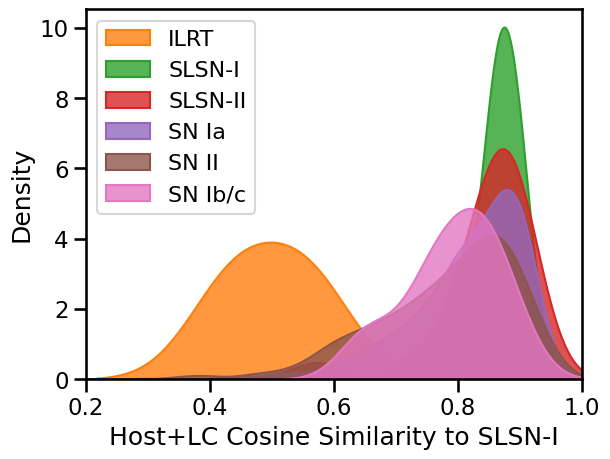

In [247]:
sns.set_context("talk")
for tempType in ['Ca-Rich', 'ILRT', 'SLSN-I', 'SLSN-II', 'SN Ia', 'SN II', 'SN Ib/c']:
    sns.kdeplot(cos_sim_joint.detach()[SN_types == tempType],  alpha=0.8, label=tempType, fill=True)
plt.legend(loc='upper left',fontsize=16)
plt.xlabel("Host+LC Cosine Similarity to SLSN-I");
plt.xlim((0.2, 1));

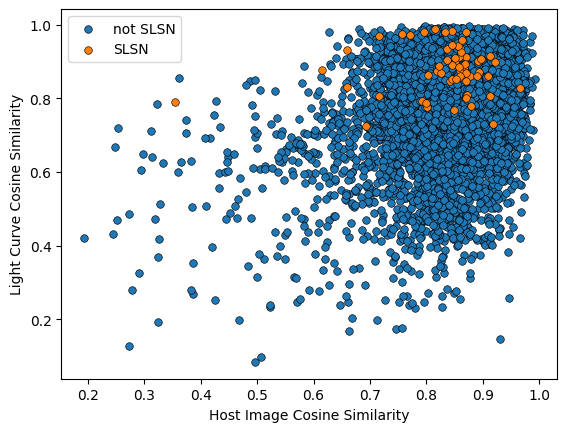

In [166]:
sns.scatterplot(x=cos_sim_im.detach()[~SLSN_bool], y=cos_sim_lc.detach()[~SLSN_bool], marker='o', s=30, ec='k',legend=False, label='not SLSN')
sns.scatterplot(x=cos_sim_im.detach()[SLSN_bool], y=cos_sim_lc.detach()[SLSN_bool], marker='o', s=30, ec='k',legend=False, label='SLSN')
plt.xlabel("Host Image Cosine Similarity");
plt.ylabel("Light Curve Cosine Similarity");
plt.legend()

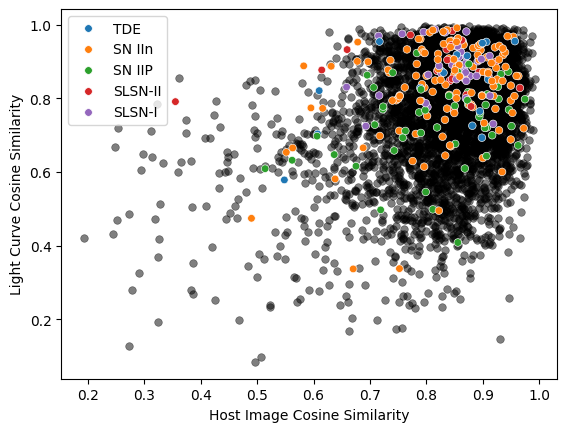

In [172]:
sns.scatterplot(x=cos_sim_im.detach()[~longlived_bool], y=cos_sim_lc.detach()[~longlived_bool], marker='o', s=30, ec='k', c='k', legend=False, alpha=0.5)
sns.scatterplot(x=cos_sim_im.detach()[longlived_bool], y=cos_sim_lc.detach()[longlived_bool], hue=SN_types[longlived_bool], marker='o', s=30, legend=True)
plt.xlabel("Host Image Cosine Similarity");
plt.ylabel("Light Curve Cosine Similarity");

### Downstream tasks: fine-tuning and classification

Since we also have access to properties like redshift, we can train a regression head on top of the learned representations, to then classify the bulk light curves.

In particular, try to just do linear regression (add a single `nn.Linear` layer on top) after freezing the learned encoder weights from either image and/or light curve representations to see if you can do inference on e.g. the redshift.